# Run random forests to determine how well we can predict biome (ScientificName) from gather profiles of metagenomes.

In [2]:
setwd("..")

In [22]:
library(readr)
library(dplyr)
library(purrr)
library(tidyr)
library(tibble)
library(ggplot2)
library(ranger)
source("scripts/utils.R")

In [5]:
set.seed(1)

In [23]:
# change default figure size
options(repr.plot.width=15, repr.plot.height=13)
# disable scientific notation (for plot axes)
options(scipen = 999)

## Read in training and testing sets generated in variable importance nb

In [11]:
train_df_filt <- read_csv("outputs/gather10k_rf/scientificname_filt_training_data.csv", show_col_types = FALSE)
test_df_filt <- read_csv("outputs/gather10k_rf/scientificname_filt_testing_data.csv", show_col_types = FALSE)

## Use tuneRanger to find recommended parameters

In [8]:
# Make an mlr task with the training dataset here 
library(tuneRanger)
tmp <- train_df_filt %>%
  column_to_rownames("query_name")
task <- makeClassifTask(data = tmp, target = "ScientificName")

# Run tuning process
res <- tuneRanger(task, num.threads = 3)

# write model parameters to a file
write_tsv(res$recommended.pars, "outputs/gather10k_rf/scientificname_tuneranger_recommended_pars.txt")

In [10]:
# read in recommended parameters to use in building optimal model
rec_pars <- read_tsv("outputs/gather10k_rf/scientificname_tuneranger_recommended_pars.txt", show_col_types = F)
rec_pars

mtry,min.node.size,sample.fraction,multiclass.brier,exec.time
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
432,2,0.8772635,0.6731578,555.9276


## Build optimal model

In [12]:
# build optimal model 
# extract model parameters and use to build an optimal RF
train_df_filt$ScientificName <- as.factor(train_df_filt$ScientificName)
optimal_rf <- ranger(
  dependent.variable.name = "ScientificName",
  mtry            = rec_pars$mtry,
  num.trees       = 1000,
  data            = train_df_filt,
  sample.fraction = rec_pars$sample.fraction,
  min.node.size   = rec_pars$min.node.size,
  seed            = 1,
  importance       = 'permutation',
  local.importance = T
)
saveRDS(optimal_rf, file = "outputs/gather10k_rf/scientificname_optimal_rf.RDS")

Growing trees.. Progress: 3%. Estimated remaining time: 15 minutes, 31 seconds.
Growing trees.. Progress: 7%. Estimated remaining time: 14 minutes, 51 seconds.
Growing trees.. Progress: 10%. Estimated remaining time: 14 minutes, 17 seconds.
Growing trees.. Progress: 13%. Estimated remaining time: 13 minutes, 44 seconds.
Growing trees.. Progress: 16%. Estimated remaining time: 13 minutes, 8 seconds.
Growing trees.. Progress: 20%. Estimated remaining time: 12 minutes, 31 seconds.
Growing trees.. Progress: 23%. Estimated remaining time: 12 minutes, 1 seconds.
Growing trees.. Progress: 27%. Estimated remaining time: 11 minutes, 27 seconds.
Growing trees.. Progress: 30%. Estimated remaining time: 10 minutes, 55 seconds.
Growing trees.. Progress: 33%. Estimated remaining time: 10 minutes, 24 seconds.
Growing trees.. Progress: 37%. Estimated remaining time: 9 minutes, 52 seconds.
Growing trees.. Progress: 40%. Estimated remaining time: 9 minutes, 20 seconds.
Growing trees.. Progress: 43%. Est

ERROR: Error in ranger(dependent.variable.name = "ScientificName", mtry = rec_pars$mtry, : User interrupt or internal error.


In [7]:
optimal_rf <- readRDS(file = "outputs/gather10k_rf/scientificname_optimal_rf.RDS")

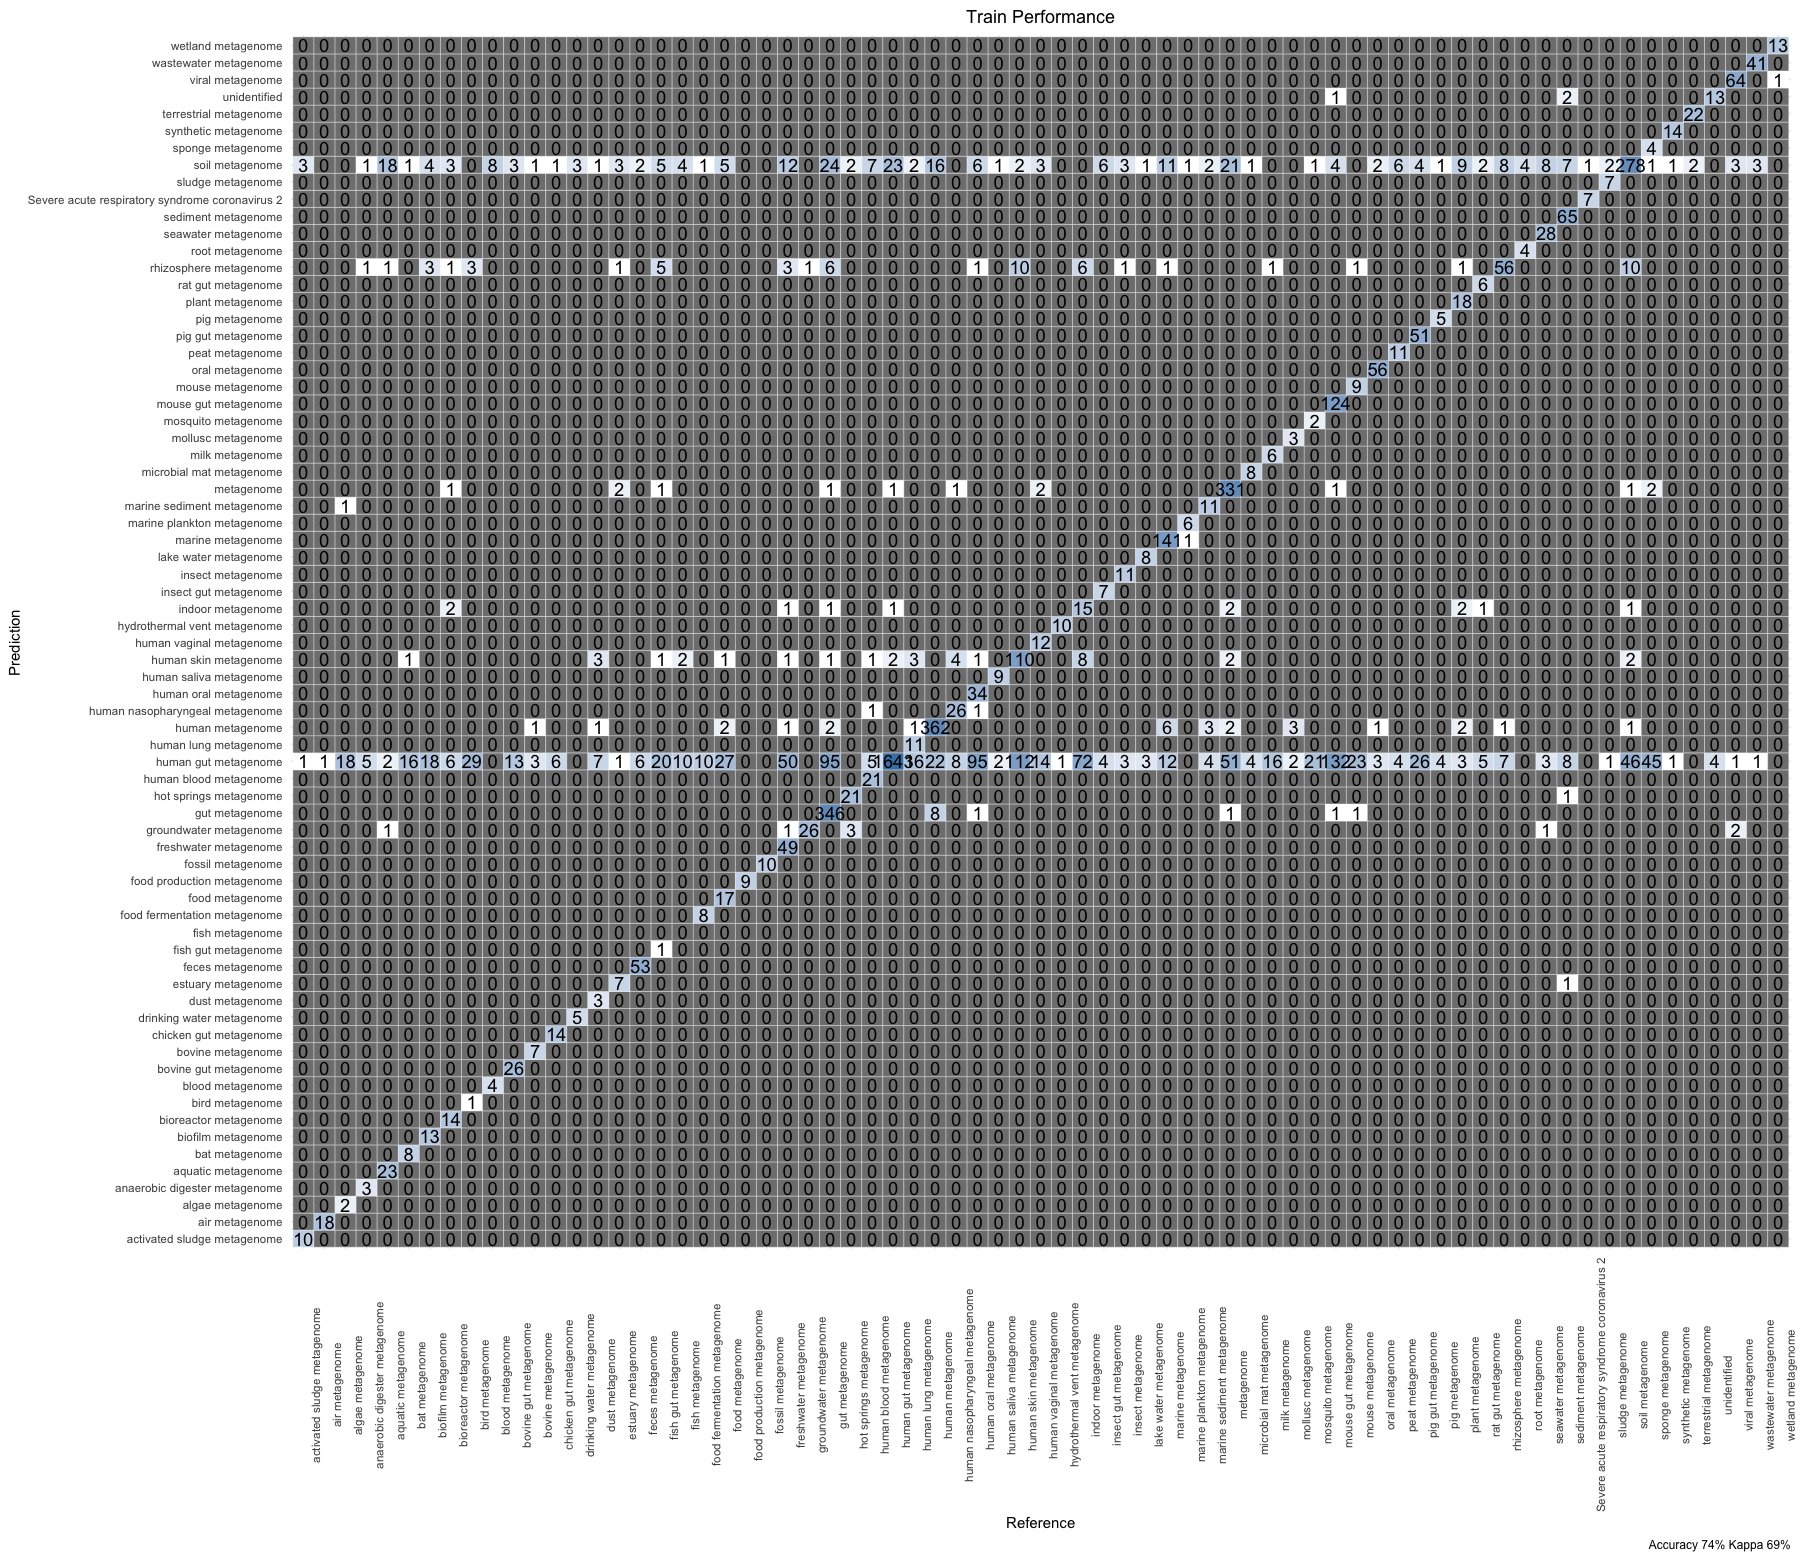

In [24]:
plt <- evaluate_model(optimal_ranger = optimal_rf,
                       data = train_df_filt, reference_class = as.factor(train_df_filt$ScientificName),
                       plt_title = "Train Performance")
plt

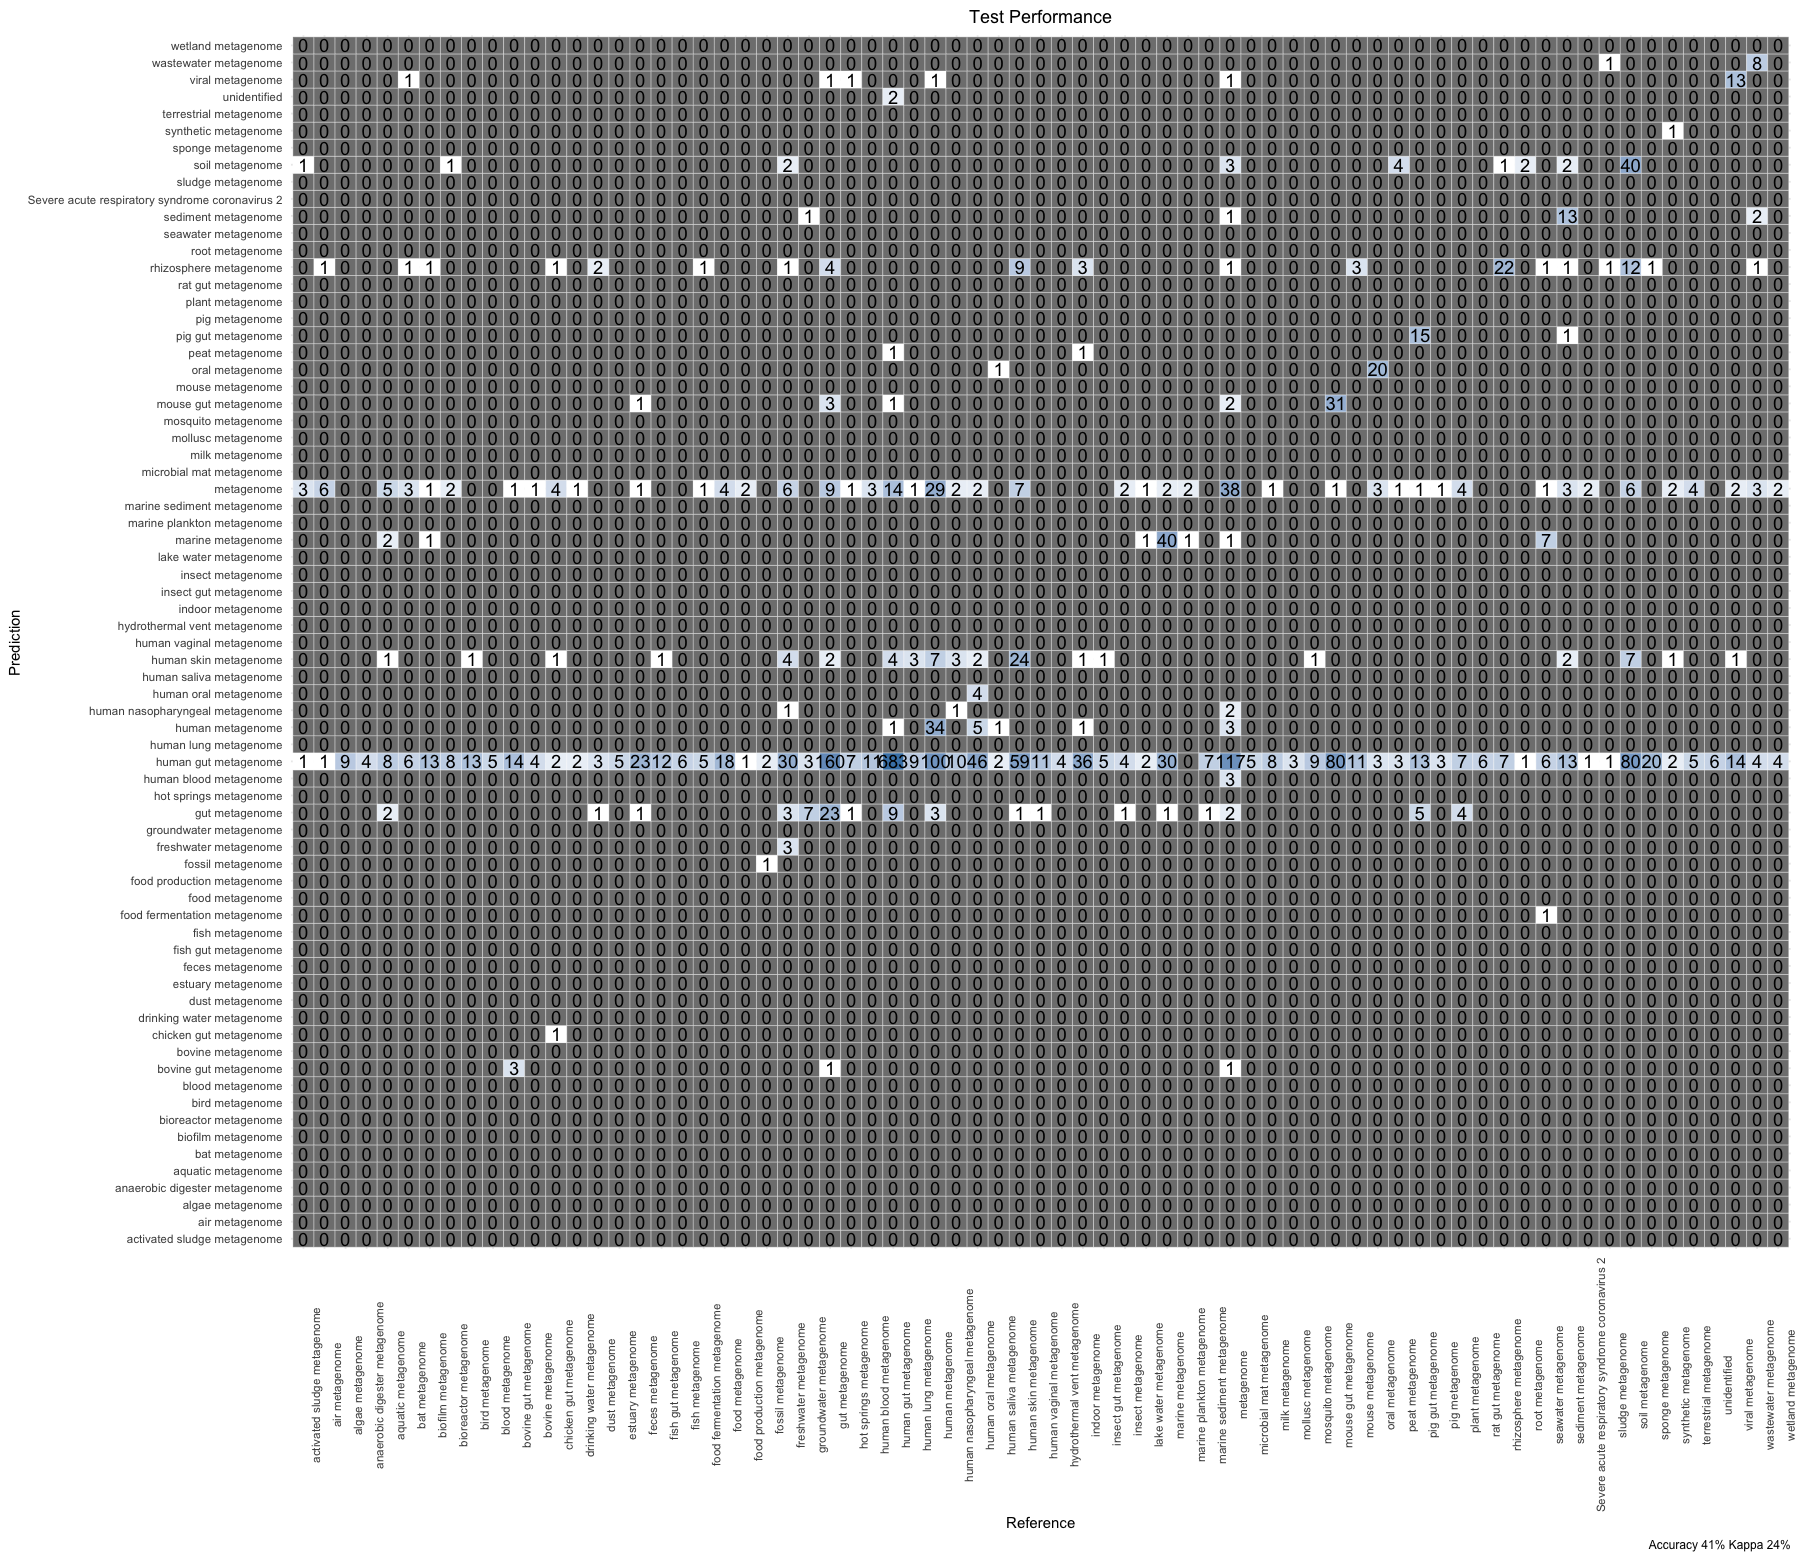

In [25]:
plt <- evaluate_model(optimal_ranger = optimal_rf,
                       data = test_df_filt, reference_class = as.factor(test_df_filt$ScientificName),
                       plt_title = "Test Performance")
plt